In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P, Utilities as U
from mppi.Calculators import Tools
from mppi.Datasets import PostProcessing as PP
import matplotlib.pyplot as plt
import numpy as np
import os

# Analysis of the effects of the RIMW on GW gap and excitonic binding energy

We perform a systematic analysis of the effect of the RIMW  procedure. 

To this scope we compare the GW gap at the K point and the first two excitonic binding energies achieved both with and without the RIMW.
The study is performed in functions of the dimension of the k-sampling.

For computational reasons we use small (unconverged) values for the relevant computational parameters. Results are expeced to be non converged,
however we are interested in understanding if the RIMW procedure leads to a faster and reliable convergence of measured quantities in function
of the dimension of the k-points sampling.

In [3]:
kpoints = [30,42,60,90]

## DFT analysis

In [4]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 16
cpus_per_task=2
omp_num_threads=2
module = '/home/dalessandro/module_script/qe_module'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h',
                memory='125000',time='11:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads,pre_processing=module)
code = C.QeCalculator(rr,activate_BeeOND=True) #,skip=False,clean_restart=False
#code.global_options()

Initialize a QuantumESPRESSO calculator with scheduler slurm


We compute the starting point DFT results on a regular grid. 

We use the sg15 pseudo and the associated converged grond state.

We include only 30 bands

In [5]:
pseudo_dir = '../pseudos'
Mo_pseudo = 'Mo_ONCV_PBE_FR-1.0.upf'
S_pseudo = 'S_ONCV_PBE_FR-1.1.upf'
run_dir = 'DFT_analysis-sg15'

alat_conv = 6.014
delta_conv = 0.4932
c = 40.0 # vacuum distance in a.u. 

ecut = 80 # energy cutoff on the wavefunction (Ry)
kp = [12,12,1]

Mo_cart = np.array([0,1./np.sqrt(3.),0.])
S1_cart = np.array([1./2.,1./(2*np.sqrt(3.)),delta_conv])
S2_cart = np.array([1./2.,1./(2*np.sqrt(3.)),-delta_conv])

inp = I.PwInput()
inp.set_scf(force_symmorphic=True,conv_thr=1e-6)
inp.set_num_bnds(28)
inp.set_pseudo_dir(pseudo_dir=pseudo_dir)
inp.set_spinorbit()
inp.add_atom(atom='Mo',pseudo_name=Mo_pseudo,mass=42.00)
inp.add_atom(atom='S',pseudo_name=S_pseudo,mass=16.00)
inp.set_atoms_number(3)
inp.set_atomic_positions([['Mo',Mo_cart],['S',S1_cart],['S',S2_cart]],type='alat')
inp.set_lattice(ibrav=4,celldm1=alat_conv,celldm3=c/alat_conv)
inp.set_energy_cutoff(ecut)
inp.set_kpoints(type='automatic',points=kp)
#inp

In [6]:
nbnds = 30
inp.set_nscf(nbnds,force_symmorphic=True,conv_thr=1e-6)

In [7]:
study = D.Dataset(run_dir=run_dir,num_tasks=2)
study.set_postprocessing_function(PP.pw_parse_data)

for k in kpoints:
    idd = {'kpoints':k,'nbnds':nbnds}
    inp.set_prefix(D.name_from_id(idd))
    inp.set_kpoints(points=[k,k,1])
    study.append_run(id=idd,input=inp,runner=code,source_dir='DFT_analysis-sg15/gs_converged.save')

Initialize a Dataset with 2 parallel tasks


In [8]:
study.ids

[{'kpoints': 30, 'nbnds': 30},
 {'kpoints': 42, 'nbnds': 30},
 {'kpoints': 60, 'nbnds': 30},
 {'kpoints': 90, 'nbnds': 30}]

In [9]:
#study.runs[3]

In [10]:
results = study.run()

Run the selection [0, 1, 2, 3] with the parallel task_groups [[0, 1], [2, 3]] 

Run the task [0, 1] 
Skip the run of kpoints_30-nbnds_30
The folder /work/dalessandro/TMDs/MoS2/DFT_analysis-sg15/kpoints_30-nbnds_30.save already exists. Source_dir DFT_analysis-sg15/gs_converged.save not copied
Skip the run of kpoints_42-nbnds_30
The folder /work/dalessandro/TMDs/MoS2/DFT_analysis-sg15/kpoints_42-nbnds_30.save already exists. Source_dir DFT_analysis-sg15/gs_converged.save not copied
Task [0, 1] ended 
 
Run the task [2, 3] 
Skip the run of kpoints_60-nbnds_30
The folder /work/dalessandro/TMDs/MoS2/DFT_analysis-sg15/kpoints_60-nbnds_30.save already exists. Source_dir DFT_analysis-sg15/gs_converged.save not copied
Skip the run of kpoints_90-nbnds_30
The folder /work/dalessandro/TMDs/MoS2/DFT_analysis-sg15/kpoints_90-nbnds_30.save already exists. Source_dir DFT_analysis-sg15/gs_converged.save not copied
Task [2, 3] ended 
 


## GW analysis

In [4]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 2
ntasks_per_node = 32 #16
cpus_per_task = 1 #2
omp_num_threads = 1 #2
module = '/home/dalessandro/module_script/yambo_module'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads,pre_processing=module)
code = C.YamboCalculator(rr,activate_BeeOND=True)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 2,
 'ntasks_per_node': 32,
 'cpus_per_task': 1,
 'omp_num_threads': 1,
 'gpus_per_node': None,
 'memory': '125000',
 'time': None,
 'partition': 'all12h',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'pre_processing': '/home/dalessandro/module_script/yambo_module',
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True,
 'fatlog': False}

We study the convergence of the GW gap at the K point.

Note that the cutoff of the various computational parameters have been reduced

In [9]:
ntasks_c = 16
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

start_band,stop_band = 26,27
K_index = {30:91,42:169,60:331,90:721}
RandGvec = 100
Randqpts = 5e6
RandGvecW = 5
EXXRLvcs = 10 # 30. # Ha
EXXRLVcs_units = 'Ha'
NGsBlkXp = 2.0 # 6.0 # Ha G size of the response function
NGsBlkXp_units = 'Ha'
BndsRnXp  = [1,30]# Bands in the response function
GbndRnge = [1,30] # Bands in the Sigma_c

study = D.Dataset(num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kpoints:
    input_dir = 'DFT_analysis-sg15/kpoints_%s-nbnds_30.save'%k
    run_dir = 'MB_analysis/kpoints_%s-nbnds_30'%k
    Tools.init_yambo_dir(yambo_dir=run_dir,input_dir=input_dir)    

    inp = I.YamboInput(args='yambo -r -k hartee -dyson n -gw0 p -V all',folder=run_dir)
    inp.set_extendOut()
    inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs)
    inp.set_bandRange(start_band,stop_band)
    inp.set_scalar_variables(CUTGeo='slab z')
    inp.set_array_variables(RandQpts=Randqpts)
    inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
    inp.set_bandRange(start_band,stop_band)
    inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=NGsBlkXp)
    inp.set_array_variables(BndsRnXp=BndsRnXp,GbndRnge=GbndRnge)
    #inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='2.1.16') # for 1 nodes on ismhpc (with 32 mpi and 1 omp per node)
    inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='4.1.16') # for 2 nodes on ismhpc (with 32 mpi and 1 omp per node)

    inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='4.1.2.2.4')
    inp.set_scalar_variables(DIP_ROLEs='k.c.v',DIP_CPU='8.2.4')
    inp.set_array_variables(units='RL',FFTGvecs=10000)
    
    # append run at K
    inp.set_kRange(K_index[k],K_index[k])
    inp.deactivate_RIM_W()
    idd = 'pp-K-kpoints_%s'%k
    jobname = [idd,'ndbs']
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=jobname)
    inp.activate_RIM_W()
    idd = 'pp-K-kpoints_%s-RIM_W'%k
    jobname = [idd,'ndbs']
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=jobname,reformat=False)

16 4
Initialize a Dataset with 1 parallel tasks
SAVE folder MB_analysis/kpoints_30-nbnds_30/SAVE already present. No operations performed.
SAVE folder MB_analysis/kpoints_42-nbnds_30/SAVE already present. No operations performed.
SAVE folder MB_analysis/kpoints_60-nbnds_30/SAVE already present. No operations performed.
SAVE folder MB_analysis/kpoints_90-nbnds_30/SAVE already present. No operations performed.


In [10]:
study.ids

['pp-K-kpoints_30',
 'pp-K-kpoints_30-RIM_W',
 'pp-K-kpoints_42',
 'pp-K-kpoints_42-RIM_W',
 'pp-K-kpoints_60',
 'pp-K-kpoints_60-RIM_W',
 'pp-K-kpoints_90',
 'pp-K-kpoints_90-RIM_W']

In [11]:
#study.runs[0]

In [13]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7] with the parallel task_groups [[0], [1], [2], [3], [4], [5], [6], [7]] 

Run the task [0] 
Skip the run of pp-K-kpoints_30
Task [0] ended 
 
Run the task [1] 
Skip the run of pp-K-kpoints_30-RIM_W
Task [1] ended 
 
Run the task [2] 
Skip the run of pp-K-kpoints_42
Task [2] ended 
 
Run the task [3] 
Skip the run of pp-K-kpoints_42-RIM_W
Task [3] ended 
 
Run the task [4] 
Skip the run of pp-K-kpoints_60
Task [4] ended 
 
Run the task [5] 
Skip the run of pp-K-kpoints_60-RIM_W
Task [5] ended 
 
Run the task [6] 
Skip the run of pp-K-kpoints_90
Task [6] ended 
 
Run the task [7] 
Skip the run of pp-K-kpoints_90-RIM_W
Task [7] ended 
 


In [14]:
results_K = [results[r] for r in [0,2,4,6]]
results_K_rimw = [results[r] for r in [1,3,5,7]]

In [15]:
gap_K, gap_K_rimw = [],[]
for ind,k in enumerate(kpoints):
    print(K_index[k])
    gap_K.append(results_K[ind].data.get_gap(k_full=K_index[k],band_full=start_band,verbose=False))
    gap_K_rimw.append(results_K_rimw[ind].data.get_gap(k_full=K_index[k],band_full=start_band,verbose=False))
gap_K, gap_K_rimw

91
169
331
721


([2.731084, 2.6696590000000002, 2.633881, 2.612371],
 [2.5865, 2.5849200000000003, 2.587812, 2.5903519999999998])

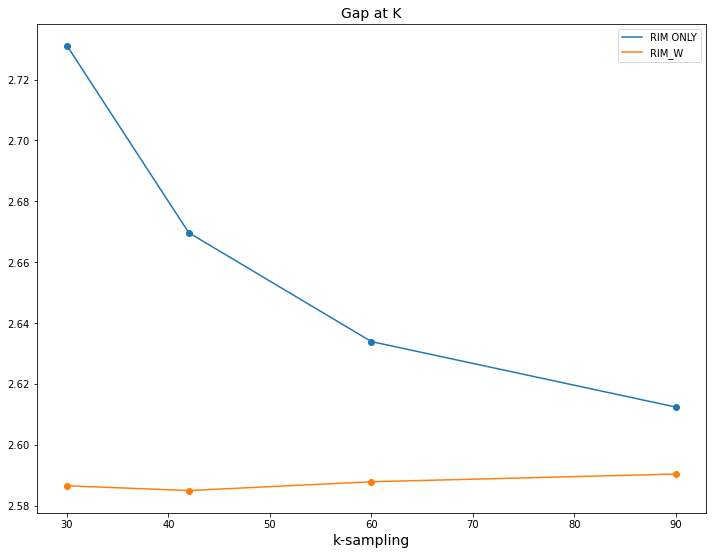

In [16]:
fig, ax = plt.subplots(figsize=(12, 9))
ax.plot(kpoints, gap_K,label='RIM ONLY')
ax.scatter(kpoints,gap_K)
ax.plot(kpoints, gap_K_rimw,label='RIM_W')
ax.scatter(kpoints,gap_K_rimw)
ax.set_title('Gap at K',size=14)
ax.set_xlabel('k-sampling',size=14)
ax.legend()

In [17]:
import scipy.optimize

In [18]:
def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b

In [45]:
p0 = (0.1, .1, 2.6) # start with values near those we expect
params, cv = scipy.optimize.curve_fit(monoExp, kpoints, gap_K, p0)
print(params)
m, t, b = params
k_fit = np.array(kpoints + [120,150])
k_fit
gap_fit = monoExp(k_fit,m,t,b)

[0.65017779 0.05589498 2.60907597]


In [47]:
p0 = (0.01, .1, 2.6) # start with values near those we expect
params, cv = scipy.optimize.curve_fit(monoExp, kpoints, gap_K_rimw, p0)
print(params)
m, t, b = params
k_fit = np.array(kpoints + [120,150])
k_fit
gap_rimw_fit = monoExp(k_fit,m,t,b)

[0.65386291 2.52799137 2.587396  ]


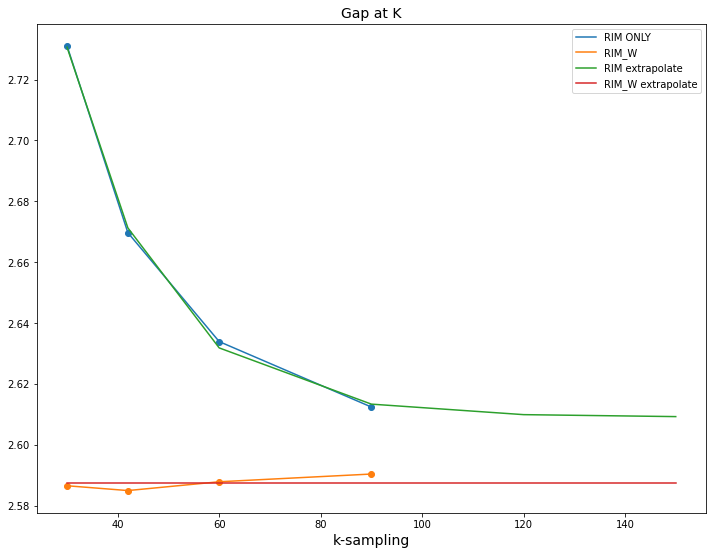

In [52]:
fig, ax = plt.subplots(figsize=(12, 9))
ax.plot(kpoints, gap_K,label='RIM ONLY')
ax.scatter(kpoints,gap_K)
ax.plot(kpoints, gap_K_rimw,label='RIM_W')
ax.scatter(kpoints,gap_K_rimw)
ax.plot(k_fit, gap_fit,label='RIM extrapolate')
#ax.scatter(k_fit, gap_fit)
ax.plot(k_fit, gap_rimw_fit,label='RIM_W extrapolate')
ax.set_title('Gap at K',size=14)
ax.set_xlabel('k-sampling',size=14)
ax.legend()

There is an estimated asymptotic difference of about 

In [51]:
1e3*(2.61-2.587)

22.999999999999687

meV

### BSE Analysis

We perform BSE calculations to discuss the convergence of the binding energy of the first exciton of MoS2

In [73]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 32 #16
cpus_per_task = 1 #2
omp_num_threads = 1 #2
module = '/home/dalessandro/module_script/yambo_module'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads,pre_processing=module)
code = C.YamboCalculator(rr,activate_BeeOND=True)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 32,
 'cpus_per_task': 1,
 'omp_num_threads': 1,
 'gpus_per_node': None,
 'memory': '125000',
 'time': None,
 'partition': 'all12h',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'pre_processing': '/home/dalessandro/module_script/yambo_module',
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True,
 'fatlog': False}

In [82]:
kpoints = [30,42,60]

In [85]:
RandGvec = 100
Randqpts = 5e6
RandGvecW = 10
#EXXRLvcs = 10. # Ha
EXXRLVcs_units = 'Ha'

BSENGBlk = 2.0 # Ha  value of the BSENGBlk variable (it can be reduced w.r.t the NGsBlkXs!)
EXXRLvcs = 10. # Ha use this value for the BSENGexx variable
FFTGvecs = 30. # Ha
elec_field = [1.,0.,0.]
BSEBands = [25,30]
BEnRange = [0.,3.] # eV
BEnSteps = 1000
BSSNEig = 20 # number of excitonic eigenvalues
damping = [0.03,0.03] # eV

study = D.Dataset(num_tasks=1,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kpoints:
    run_dir = 'MB_analysis/kpoints_%s-nbnds_30/'%k
    inp = I.YamboInput('yambo -r -o b -k sex -y s',folder=run_dir)
    inp.activate_RIM_W()   
    inp.set_scalar_variables(CUTGeo='slab z')
    inp.set_array_variables(RandQpts=Randqpts)
    inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
    inp.set_array_variables(units='Ha',BSENGexx=EXXRLvcs,BSENGBlk=BSENGBlk,FFTGvecs=FFTGvecs)
    inp.set_array_variables(BLongDir=elec_field) #,KfnQP_E=[scissor,1.,1.]
    inp.set_array_variables(units='eV',BEnRange=BEnRange,BDmRange=damping)
    inp.set_scalar_variables(BSEprop= 'abs esrt')
    inp.set_scalar_variables(DBsIOoff='BS') # turn off the I/O of the BSE kernel
    inp.set_scalar_variables(BS_CPU='16.2.1',BS_ROLEs= 'k.eh.t')     
    inp.set_array_variables(BSEBands=BSEBands,BEnSteps=BEnSteps,BSSNEig=BSSNEig)
    
    inp.deactivate_RIM_W()
    idd = 'bse-kpoints_%s'%k
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=[idd,',ndbs'],reformat=True)
    inp.activate_RIM_W()
    idd = 'bse-kpoints_%s-RIM_W'%k
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=[idd,',ndbs'],reformat=False)

Initialize a Dataset with 1 parallel tasks


In [86]:
study.ids

['bse-kpoints_30',
 'bse-kpoints_30-RIM_W',
 'bse-kpoints_42',
 'bse-kpoints_42-RIM_W',
 'bse-kpoints_60',
 'bse-kpoints_60-RIM_W']

In [87]:
#study.runs[0]

In [ ]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5] with the parallel task_groups [[0], [1], [2], [3], [4], [5]] 

Run the task [0] 
Skip the run of bse-kpoints_30
Task [0] ended 
 
Run the task [1] 
Skip the run of bse-kpoints_30-RIM_W
Task [1] ended 
 
Run the task [2] 
Skip the run of bse-kpoints_42
Task [2] ended 
 
Run the task [3] 
Skip the run of bse-kpoints_42-RIM_W
Task [3] ended 
 
Run the task [4] 
run command: mpirun -np 32 yambo -F bse-kpoints_60.in -J "bse-kpoints_60,,ndbs" -C bse-kpoints_60
slurm submit:  cd MB_analysis/kpoints_60-nbnds_30/ ; sbatch job_bse-kpoints_60.sh
computation bse-kpoints_60 is running...


In [79]:
eigen_index = 0
exc_eng = [results[ind].data['Esort_q1_slepc_bse']['energy'][eigen_index] for ind in [0,2,4]]
exc_eng_rimw = [results[ind].data['Esort_q1_slepc_bse']['energy'][eigen_index] for ind in [1,3,5]]
exc_eng,exc_eng_rimw

([0.71342, 0.786294], [0.889899, 0.890216])

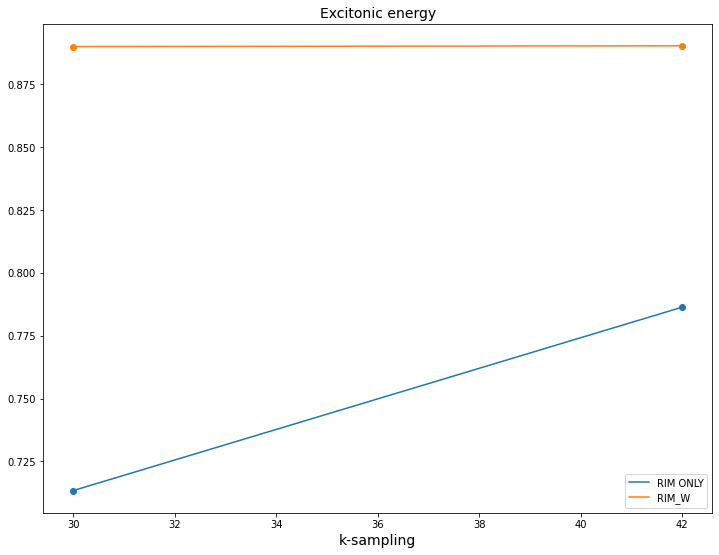

In [81]:
fig, ax = plt.subplots(figsize=(12, 9))
ax.plot(kpoints, exc_eng,label='RIM ONLY')
ax.scatter(kpoints,exc_eng)
ax.plot(kpoints, exc_eng_rimw,label='RIM_W')
ax.scatter(kpoints,exc_eng_rimw)
ax.set_title('Excitonic energy',size=14)
ax.set_xlabel('k-sampling',size=14)
ax.legend()